# Cat and Dog classifier using pretrained model VGG-16

## Importing the required libraries and reading the dataset:

In [8]:
import numpy as np 
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
# Reading images and datas
from pathlib import Path
from PIL import Image
import cv2

In [9]:
train_data = '/kaggle/input/cat-and-dog/training_set/training_set'
train_data = Path(train_data)

test_data = '/kaggle/input/cat-and-dog/test_set/test_set'
test_data = Path(test_data)

## Here lets read the paths for images from the folders:

In [10]:
train_animals = {
    'dog': list(train_data.glob('dogs/*.*')),
    'cat': list(train_data.glob('cats/*.*'))
}
labels = {
    'dog' : 1,
    'cat' : 0
}

## Splitting the Data

<p style="font-size: 16px; color: #22b2a3;">
    I'm going to split the data into a <span style="color: #3498db;">training set</span> and a <span style="color: #3498db;">validation set</span>, since there is already a <span style="color: #3498db;">test set</span> in the dataset, so we don't need to create one.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    I'll store the <strong>file paths</strong> in a list so that I can perform some preprocessing on the images later.
</p>


In [11]:
from sklearn.model_selection import train_test_split

# Assuming 'animals' contains the file paths as you already have
image_paths = []
image_labels = []

for name, images in train_animals.items():
    for image in images:
        image_paths.append(str(image))
        image_labels.append(labels[name])  # 1 for dog, 0 for cat

# Convert to NumPy arrays
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# Perform train-test split (on file paths, not images themselves)
# First split: train and temp (test+validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)


## Data preprocessing:

## Preprocessing the Images

<p style="font-size: 16px; color: #22b2a3;">
    What did I do for preprocessing?
</p>

<p style="font-size: 16px; color: #22b2a3;">
    I used the <strong>CV2</strong> library to read the images from the paths and resized them to <span style="color: #3498db;">224x224x3</span>.
</p>

<h3 style="font-size: 18px; color: #16a085;">Why did I do that?</h3>

<p style="font-size: 16px; color: #22b2a3;">
    The <strong>VGG-16</strong> model expects inputs to be of size <span style="color: #3498db;">224x224x3</span>, so for the fine-tuning process, this resizing was necessary.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    Then, I applied <strong>rescaling</strong> to normalize the pixel values, putting them between <span style="color: #3498db;">0 and 1</span> for easier implementation.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    I used batches of <strong>16</strong>, stored the images in a list, and then grouped them into batches.
</p>


In [12]:
# Custom function to load images from paths
def path_to_images(paths, labels, batch_size):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            images = []
            for path in batch_paths:
                img = cv2.imread(path)  # Load the image
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize to match VGG16 input
                    images.append(img)
                else:
                    images.append(np.zeros((224, 224, 3)))  # Handle unreadable images

            images = np.array(images)
            batch_labels = np.array(batch_labels).reshape(-1, 1)  # Reshape labels to match the batch size
            yield images, batch_labels


# Set batch size
batch_size = 16

# Create generators using the custom path_to_images function for train and validation
train_generator = path_to_images(train_paths, train_labels, batch_size)
val_generator = path_to_images(val_paths, val_labels, batch_size)

In [13]:
# Print the total number of images
print(f"Total number of images in train set: {len(train_paths)}")
print(f"Total number of images in validation set: {len(val_paths)}")

Total number of images in train set: 6804
Total number of images in validation set: 1201


In [14]:
# Function to print label distribution
def print_label_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution in {dataset_name}:")
    for label, count in label_distribution.items():
        print(f"Label {label}: {count} samples")
    print("\n")

# Check diversity of labels in train, validation, and test sets
print_label_distribution(train_labels, "Training Set")
print_label_distribution(val_labels, "Validation Set")


Label distribution in Training Set:
Label 0: 3400 samples
Label 1: 3404 samples


Label distribution in Validation Set:
Label 0: 600 samples
Label 1: 601 samples




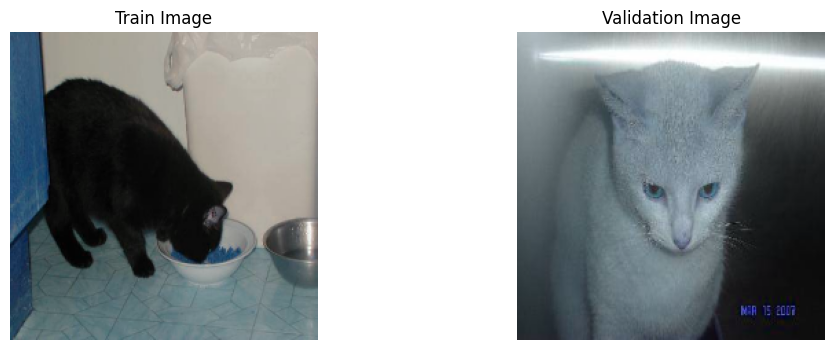

In [15]:
import matplotlib.pyplot as plt

# Function to get the first image from a generator
def get_first_image(generator):
    images, labels = next(generator)  # Get the first batch of images and labels
    first_image = images[0]  # Get the first image in the batch
    return first_image


# Get the first images from the padded generators
first_train_image = get_first_image(train_generator)
first_val_image = get_first_image(val_generator)

# Function to display images side by side
def display_images_side_by_side(images, titles):
    plt.figure(figsize=(12, 4))
    
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.show()

# List of first images and their respective titles
images = [first_train_image, first_val_image]
titles = ['Train Image', 'Validation Image']

# Display the images side by side
display_images_side_by_side(images, titles)


## Model trainig(Using the Pretrained VGG Model): 

<p style="font-size: 16px; color: #22b2a3;">
    In this part, I'm trying to call the pretrained <strong>VGG</strong> model. However, there's a problem: the VGG model is designed for <span style="color: #3498db;">1000 different classes</span>. Since I'm working with a <span style="color: #3498db;">binary classification</span> task (cats and dogs), I need to modify the final layers.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    I added one <strong>fully connected (FC) layer</strong> with <span style="color: #3498db;">256 units</span> and a <strong>dropout</strong> of <span style="color: #3498db;">30%</span>.
</p>


In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers



# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False



# Build the custom model on top of the VGG16 base
model = models.Sequential([
    base_model,  # Pre-trained VGG16 without the top layers
    layers.Flatten(),  # Flatten the output of the convolutional base
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary output layer for cats/dogs
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Results: 

<p style="font-size: 16px; color: #22b2a3;">
    As you can see, there are a few unusual patterns in the <span style="color: #3498db;">validation loss</span> and <span style="color: #3498db;">validation accuracy</span>, which is a clear sign of <strong>overfitting</strong>.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    In this version of the code, I'm going to continue with the current setup because the loss and differences are not that significant.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    However, in the future, I plan to implement a more accurate and improved model to address this issue.
</p>


In [17]:
# Number of steps per epoch (total samples / batch size)
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size

# Train the model with steps specified
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5, 
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/5


I0000 00:00:1728055073.287912     979 service.cc:145] XLA service 0x5938c2abf640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728055073.287960     979 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/425 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.7118 - loss: 9.2789  

I0000 00:00:1728055080.123413     979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


425/425 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - accuracy: 0.8923 - loss: 0.7451 - val_accuracy: 0.9536 - val_loss: 0.1136
Epoch 2/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9678 - loss: 0.0929 - val_accuracy: 0.9758 - val_loss: 0.0723
Epoch 3/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9814 - loss: 0.0591 - val_accuracy: 0.9688 - val_loss: 0.1841
Epoch 4/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9813 - loss: 0.0576 - val_accuracy: 0.9806 - val_loss: 0.1062
Epoch 5/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9867 - loss: 0.0505 - val_accuracy: 0.9705 - val_loss: 0.1106


# Using the test set:


<p style="font-size: 16px; color: #22b2a3;">
    In the test set, I'm going to apply the same preprocessing methods used in the <span style="color: #3498db;">training set</span>.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    After that, I'll proceed to predict the results for the test set.
</p>


In [18]:
test_animals = {
    'dog': list(test_data.glob('dogs/*.*')),
    'cat': list(test_data.glob('cats/*.*'))
}
test_labels = {
    'dog' : 1,
    'cat' : 0
}

In [19]:
from sklearn.model_selection import train_test_split

# Assuming 'animals' contains the file paths as you already have
image_paths = []
image_labels = []

for name, images in test_animals.items():
    for image in images:
        image_paths.append(str(image))
        image_labels.append(test_labels[name])  # 1 for dog, 0 for cat

# Convert to NumPy arrays
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)



In [23]:
# Test generator
test_generator = path_to_images(image_paths, image_labels, batch_size)

In [26]:
# Predicting the test dataset
predictions = model.predict(test_generator, steps=len(image_paths) // batch_size + 1, verbose=1)

# Since predictions are probabilities, you may want to round them
predicted_labels = (predictions > 0.5).astype(int)

# Ensure both `predicted_labels` and `true_labels` have the same number of samples
predicted_labels = predicted_labels[:len(image_paths)]


127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step


In [27]:
from sklearn.metrics import confusion_matrix, classification_report

# Collect true labels from test generator
true_labels = []
for _, labels in test_generator:
    true_labels.extend(labels)
    if len(true_labels) >= len(image_paths):
        break

true_labels = np.array(true_labels[:len(image_paths)]).flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Optional: Generate classification report for precision, recall, etc.
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=['cat', 'dog']))


Confusion Matrix:
 [[965  46]
 [ 71 941]]
Classification Report:
               precision    recall  f1-score   support

         cat       0.93      0.95      0.94      1011
         dog       0.95      0.93      0.94      1012

    accuracy                           0.94      2023
   macro avg       0.94      0.94      0.94      2023
weighted avg       0.94      0.94      0.94      2023



## Results for the test set: 


<p style="font-size: 16px; color: #22b2a3;">
    As you can see, the model is doing a pretty good job predicting the classes.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    It correctly predicted <span style="color: #3498db;">965</span> instances of cats and <span style="color: #3498db;">941</span> instances of dogs. However, <span style="color: #3498db;">71</span> cat instances and <span style="color: #3498db;">46</span> dog instances were predicted incorrectly.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    In the future, I will work on implementing a better model to address these remaining issues.
</p>


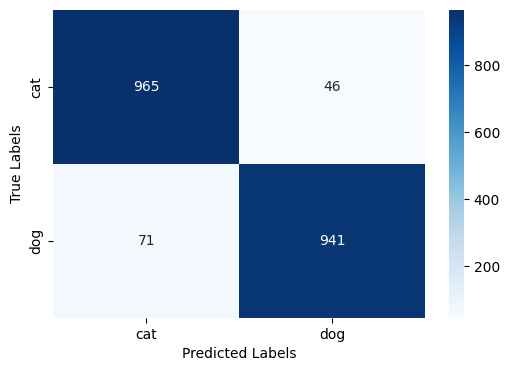

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [29]:
model.save('cat_dog_classifier.h5')

## Final Thoughts

<p style="font-size: 16px; color: #22b2a3;">
    Thank you for your attention! If you have any ideas that could help improve the model's predictions, I would be happy to hear your suggestions.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    If you have any questions, feel free to comment here or contact me via email at: <span style="color: #3498db;">Shahbods26@gmail.com</span>.
</p>
